In [3]:
import os
import sys

import paddle
import paddle.nn as nn
import numpy as np

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from paddlenlp.seq2vec import TCNEncoder

import paddlenlp
paddlenlp.__version__

'2.2.0'

In [4]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [5]:
# !wget https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In [6]:
# import requests
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# res = requests.get(url, allow_redirects=True)
# with open('cases.csv','wb') as file:
#     file.write(res.content)
    
df_all = pd.read_csv('cases.csv')
df_all.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,157387,157412,157431,157445,157499,157508,157542,157585,157858,157858
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,200639,201045,201402,201730,201902,202295,202641,202863,203215,203524
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,210921,211112,211297,211469,211662,211859,212047,212224,212434,212652
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,17658,18010,18010,18010,18631,18815,18815,19272,19440,19440
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,65208,65223,65244,65259,65259,65301,65332,65346,65371,65397


In [7]:
df = df_all.iloc[:, 4:]
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

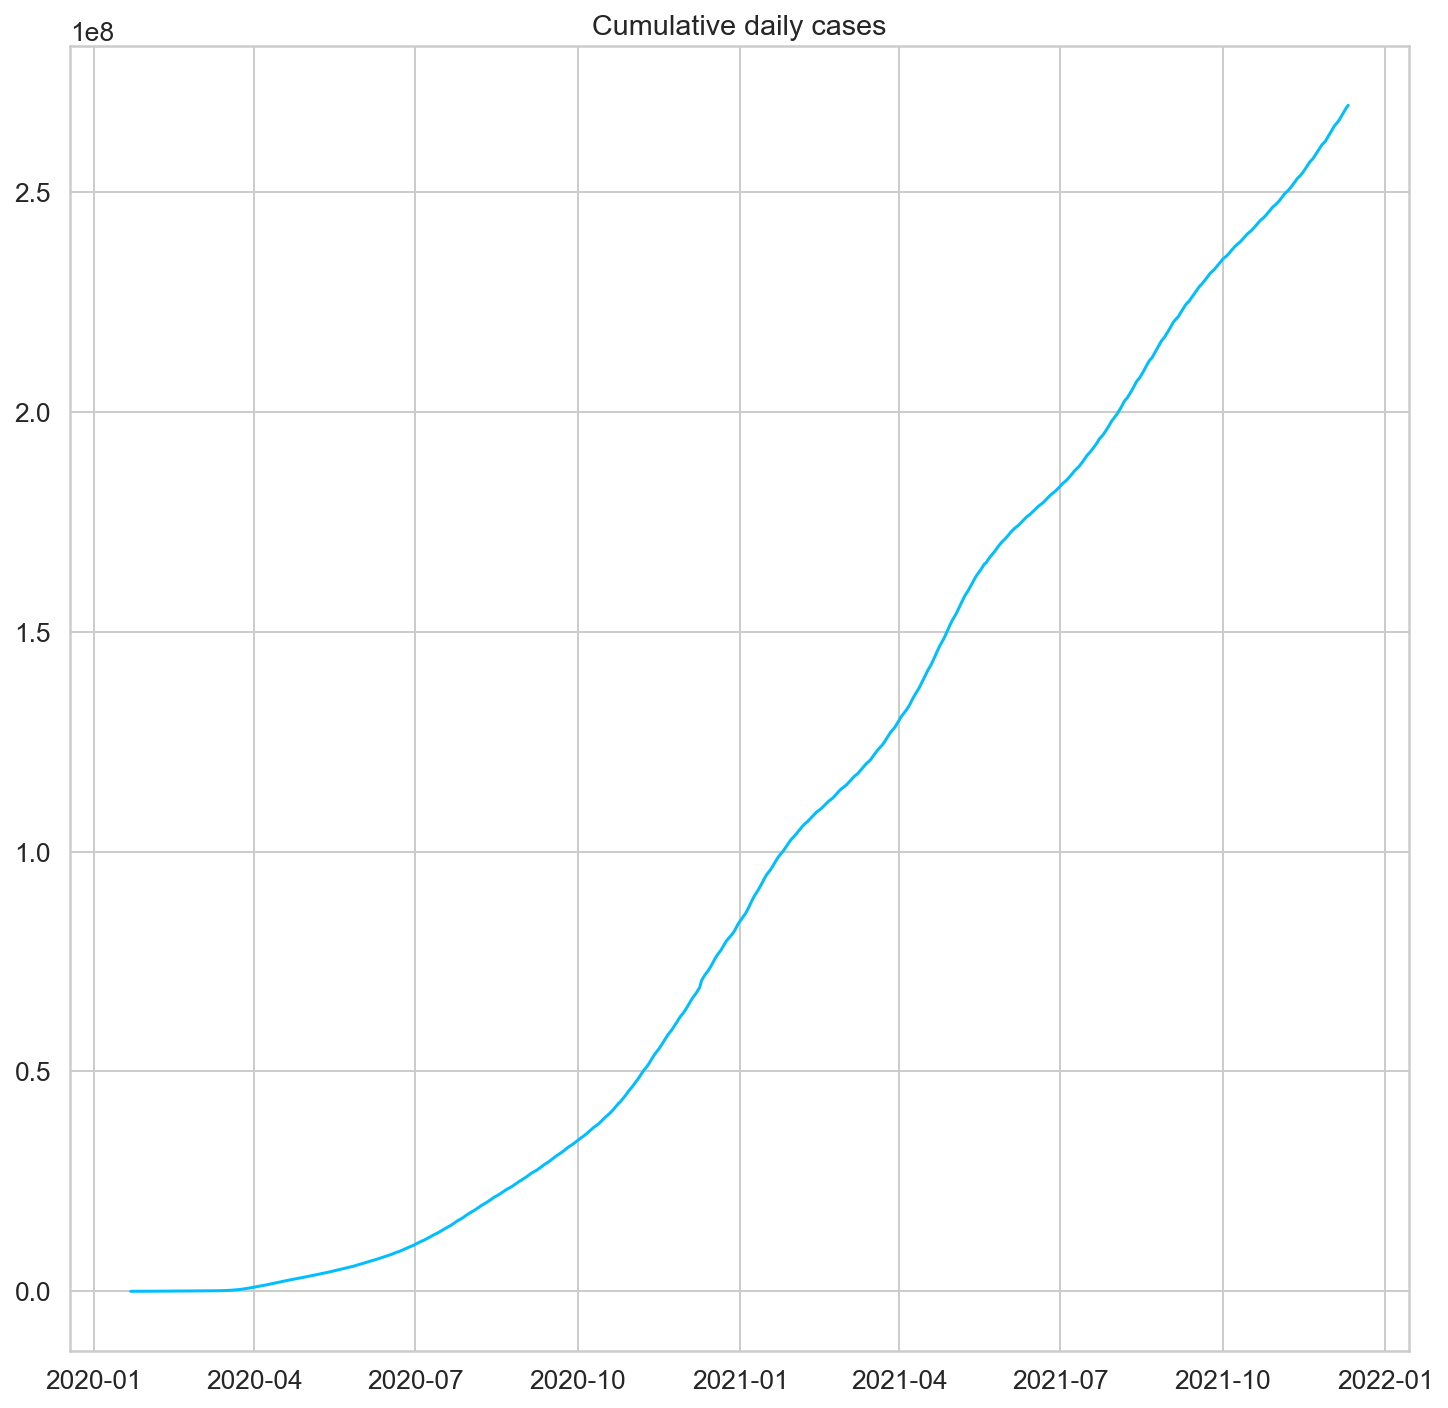

In [8]:
plt.figure(figsize=(12,12))
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [9]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23     98
2020-01-24    286
2020-01-25    493
2020-01-26    684
dtype: int64

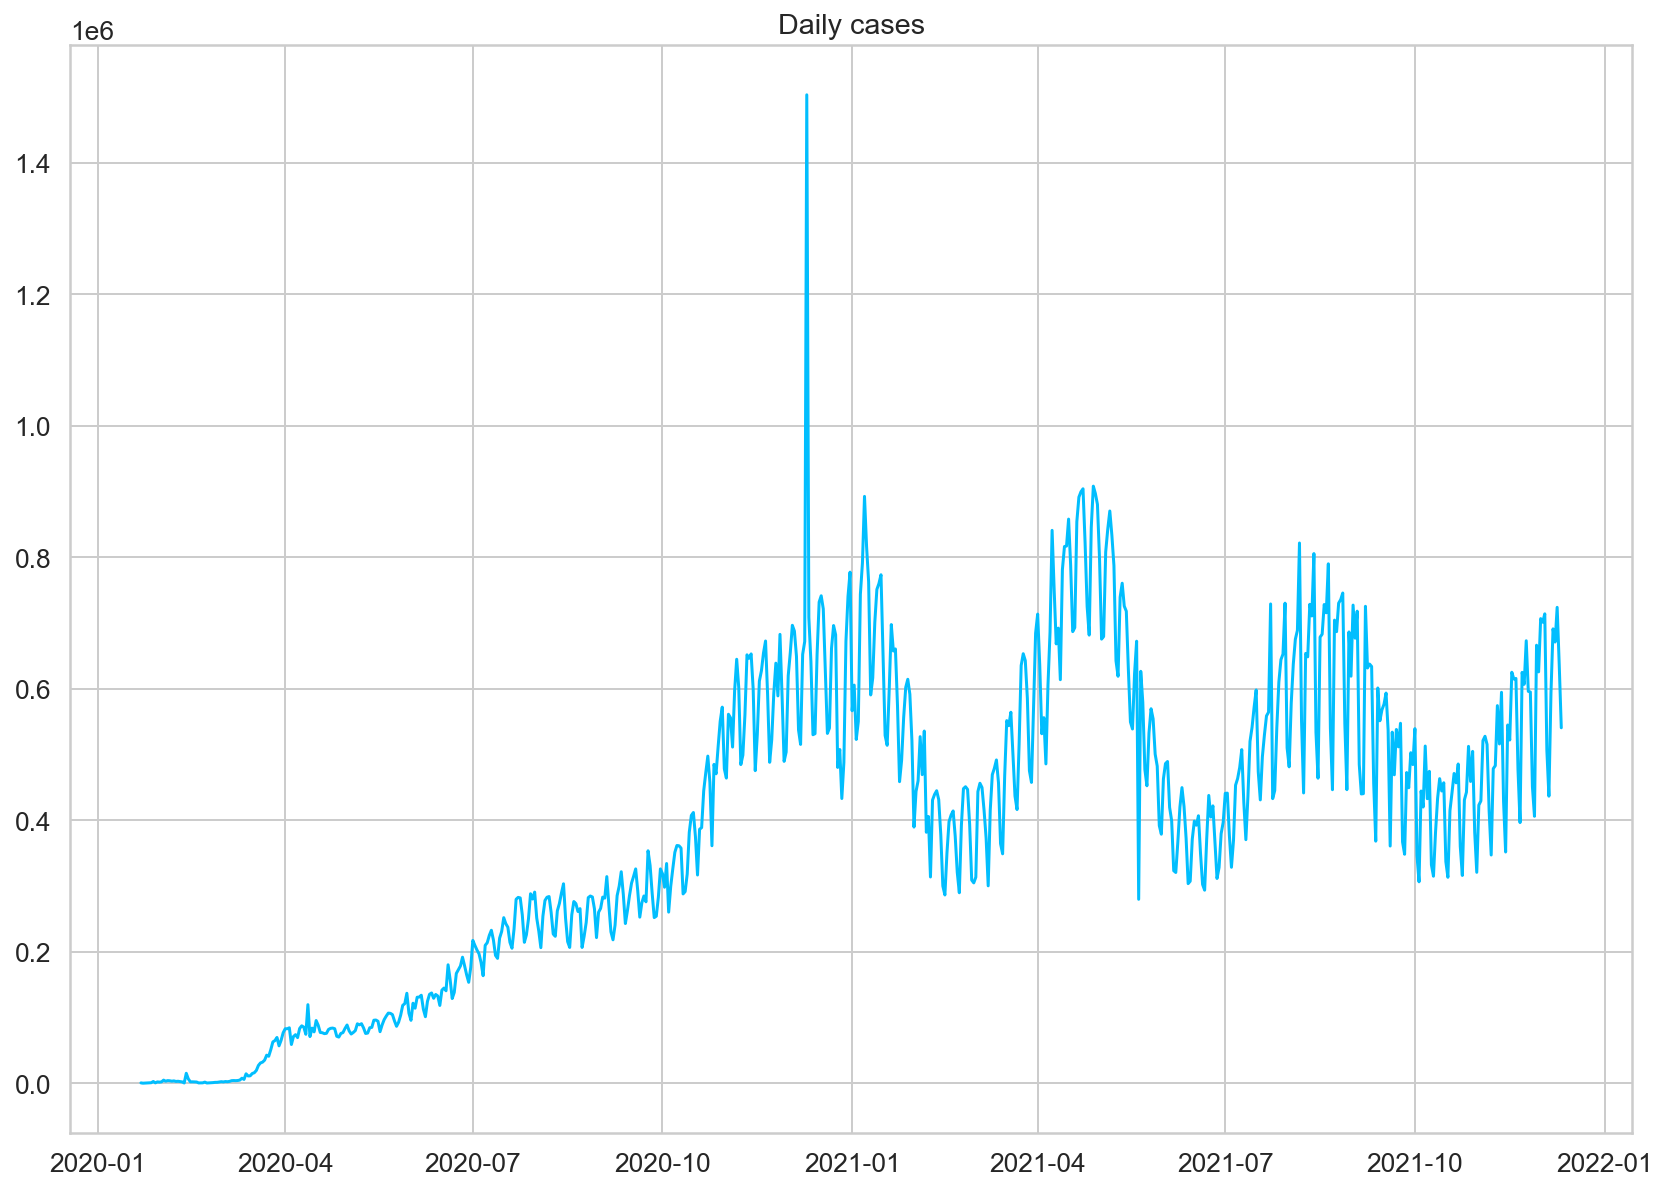

In [10]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [11]:
TEST_DATA_SIZE = 30

train_data = daily_cases[:-TEST_DATA_SIZE]
test_data = daily_cases[-TEST_DATA_SIZE:]

print("The number of the samples in train set is : %i"%train_data.shape[0])

The number of the samples in train set is : 660


In [12]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(np.expand_dims(train_data, axis=1)).astype('float32')
test_data = scaler.transform(np.expand_dims(test_data, axis=1)).astype('float32')

In [13]:
SEQ_LEN = 10

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length+1):
        x = data[i:i+seq_length-1]
        y = data[i+seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, SEQ_LEN)
test_data = np.concatenate((train_data[-SEQ_LEN+1:],test_data),axis=0)
x_test, y_test = create_sequences(test_data, SEQ_LEN)

print("The shape of x_train is: %s"%str(x_train.shape))
print("The shape of y_train is: %s"%str(y_train.shape))
print("The shape of x_test is: %s"%str(x_test.shape))
print("The shape of y_test is: %s"%str(y_test.shape))

The shape of x_train is: (651, 9, 1)
The shape of y_train is: (651, 1)
The shape of x_test is: (30, 9, 1)
The shape of y_test is: (30, 1)


In [14]:

class CovidDataset(paddle.io.Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        super(CovidDataset, self).__init__()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        return [self.feature[index], self.label[index]]

train_dataset = CovidDataset(x_train, y_train)
test_dataset = CovidDataset(x_test, y_test)

In [15]:
class TimeSeriesNetwork(nn.Layer):

  def __init__(self, input_size, next_k=1, num_channels=[64,128,256]):
    super(TimeSeriesNetwork, self).__init__()

    self.last_num_channel = num_channels[-1]

    self.tcn = TCNEncoder(
      input_size=input_size,
      num_channels=num_channels,
      kernel_size=2, 
      dropout=0.2
    )

    self.linear = nn.Linear(in_features= self.last_num_channel, out_features=next_k)

  def forward(self, x):
    tcn_out = self.tcn(x)
    y_pred = self.linear(tcn_out)
    return y_pred

network = TimeSeriesNetwork(input_size=1)

In [16]:

LR = 1e-3

model = paddle.Model(network)

optimizer = paddle.optimizer.Adam(
        learning_rate=LR, parameters=model.parameters())

loss = paddle.nn.MSELoss(reduction='sum')

model.prepare(optimizer, loss)

In [17]:
USE_GPU = False
TRAIN_EPOCH = 100
LOG_FREQ = 10
SAVE_DIR = os.path.join(os.getcwd(),"save_dir")
SAVE_FREQ = 10

if USE_GPU:
    paddle.set_device("gpu")
else:
    paddle.set_device("cpu")

model.fit(train_dataset, 
    batch_size=32,
    drop_last=True,
    epochs=TRAIN_EPOCH,
    log_freq=LOG_FREQ,
    save_dir=SAVE_DIR,
    save_freq=SAVE_FREQ,
    verbose=1
    )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/100
step 20/20 [==============================] - loss: 0.5490 - 54ms/step          
save checkpoint at C:\Users\19337\0_毕设\save_dir\0
Epoch 2/100
step 20/20 [==============================] - loss: 0.4438 - 46ms/step          
Epoch 3/100
step 20/20 [==============================] - loss: 0.2278 - 48ms/step          
Epoch 4/100
step 20/20 [==============================] - loss: 0.3071 - 48ms/step          
Epoch 5/100
step 20/20 [==============================] - loss: 0.1882 - 47ms/step          
Epoch 6/100
step 20/20 [==============================] - loss: 0.0889 - 47ms/step          
Epoch 7/100
step 20/20 [==============================] - loss: 0.1833 - 48ms/step          
Epoch 8/100
step 20/20 [==============================] - loss: 0.2616 - 47ms/step          
Epoch 9/100
step 20/20 [==============================] - loss: 0.0812 - 47ms/step          
Epo

In [18]:
preds = model.predict(
        test_data=test_dataset
        )

Predict begin...
step 30/30 [==============================] - 8ms/step          
Predict samples: 30


In [19]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(np.array(preds).flatten(), axis=0)
).flatten()

In [20]:
print (type(daily_cases))
daily_cases[1:3]
print (len(daily_cases), len(train_data))
daily_cases.index[:len(train_data)]

<class 'pandas.core.series.Series'>
690 660


DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
               '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
               '2021-11-10', '2021-11-11'],
              dtype='datetime64[ns]', length=660, freq=None)

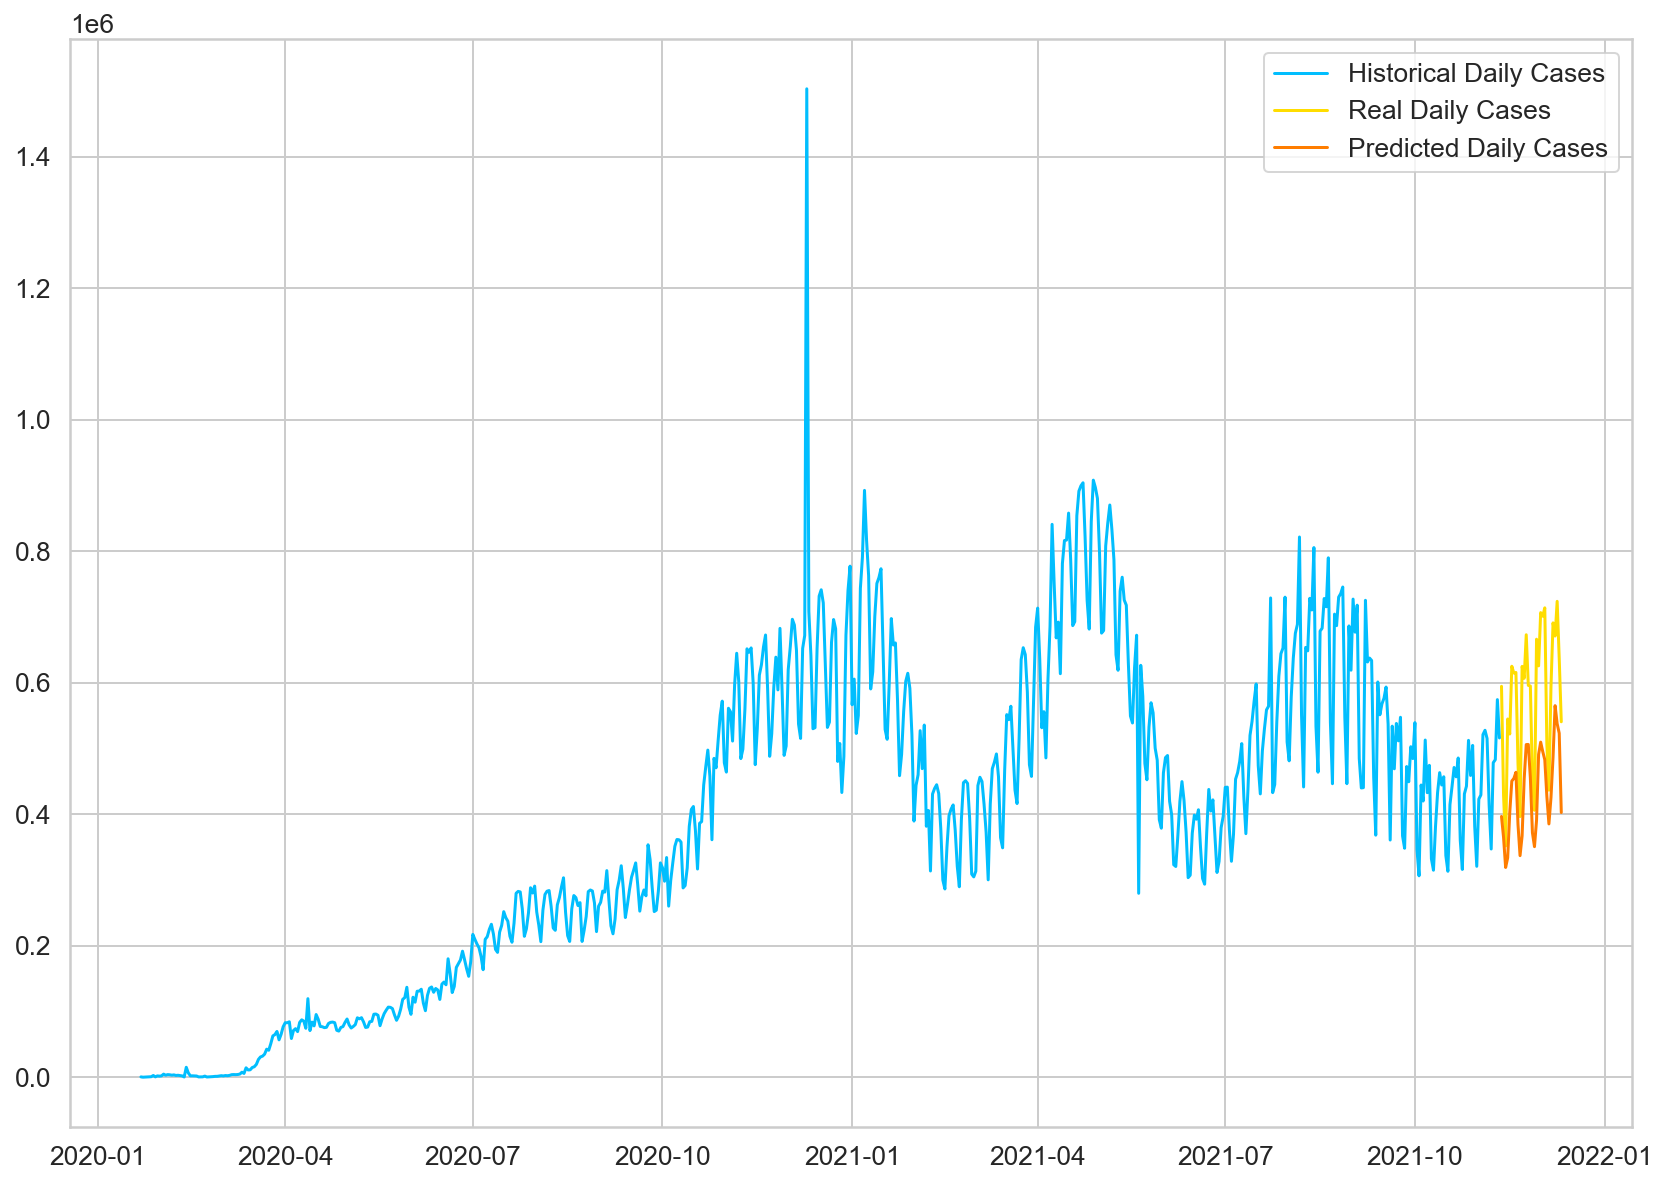

In [21]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();